# MODIS 


## get data

* [NASA Earth Observations (NEO)](https://neo.sci.gsfc.nasa.gov/view.php?datasetId=MY1DMW_CHLORA&date=2019-02-01) site
  - No bounding box
  - Can select monthly averages or 8-day
  - Clicking on `Download raw data` produces 45MB files at 0.1 deg resolution as NetCDF
* MODIS Chlorophyll Level 1 and 2 data are [here](http://oceancolor.gsfc.nasa.gov/cgi/browse.pl?sen=am)
* MODIS Chlorophyll Level 3 data are [here](http://oceancolor.gsfc.nasa.gov/cgi/l3)


## ...on) a map

This notebook takes a look at how to superimpose a MODIS image on a map


**Missing: How this data file is pulled into the local data directory...**

In [1]:
%matplotlib inline

!pip install utm
!pip install pygeotools

import timeit
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri

from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
import utm

# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

import golive_utility as g

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
# verify the MODIS example file is present
modis_d = g.SetDataDirectory('modis')
image_d = g.SetDataDirectory('images')
g.lsal(modis_d)

In [ ]:
g.lsal(image_d)

In [ ]:
# check: can open_msdataset work against multiple MODIS *.nc files?

# standard inputs plus assign the modis data to a dataset list as element 0 of m[]

if not os.path.exists(modis_d):
    print('sorry the modis directory does not seem to be present where I expected it (~/data/modis)')
    sys.exit(0)
    
fnm_field_index = 8                                          # index of the filename after the ls line is split
m=[]                                                         # a list of MODIS datasets
stipulate = '*MODIS*.nc'                                     # profiles; not trajectories for now
r = os.popen('ls -al ' + modis_d + stipulate).readlines()   # list of MODIS netCDF data files

for q in r:
    b=q.split()[fnm_field_index].rstrip()   # filename with no whitespace
    m.append(xr.open_mfdataset(b))          # ds now a working dataset list (with but one element)

print('Number of modis datasets: ', len(m))

In [ ]:
modis = m[0]
print(modis.MODISA_L3m_SST_2014_sst)
print(modis.lat.values[0], modis.lon.values[0], modis.lat.values[-1], modis.lon.values[-1])
modisplot = modis.MODISA_L3m_SST_2014_sst.plot(figsize=(12,12))

### intermezzo remarks

- The image saver below does not work properly; I just get an empty image...
- The nbextension command should *not* be necessary but it is for the record:
  
```
jupyter nbextension enable --py --sys-prefix ipyleaflet
```

- install the MODIS WMS from [here](https://lpdaac.usgs.gov/data_access/web_map_services_wms)

So basically lots to do here.

In [ ]:
# bug: This does not work properly yet

# plt.savefig(data + '/images/modis_SST.png')
import matplotlib
img=matplotlib.image.imread(image_d + 'modis_sst.png')
imgplot = plt.imshow(img)
# plt.show()

In [ ]:
# The goal is to overlay an image (created earlier; .png file) with a controllable opacity
# 
# How I got to opacity control through a sequence of print statements: 
#   print(thisMap)
#   print(thisMap.layers)
#   print(thisMap.layers[1])                    which is cheating by hardcoding the layer index as 1
#   print(thisMap.layers[1].opacity)
#   therefore setting thisMap.layers[1].opacity = 0.2 works just fine

def ChangeMapOpacity(opacity):thisMap.layers[1].opacity = opacity

from ipyleaflet import Map, ImageOverlay, WMSLayer
opacity = 0.7
thisMap = Map(center=(47, -129), zoom=5, layout=Layout(width='100%', height='600px'))
# The path to the image for overlay is relative; I could not get an absolute path to work...
sourceImage =  '../data/images/modis_sst.png'
image_layer = ImageOverlay(url=sourceImage, bounds=((40.2, -138.58), (53.8, -122.45)), opacity=opacity)
thisMap.add_layer(image_layer)


interact(ChangeMapOpacity, opacity = widgets.FloatSlider(min=0., max=1., step=0.025, value=opacity, 
      continuous_update=False, display='Opacity'))

# It seems that 'thisMap' must be the last line of code in the cell, hence placing interact() above
thisMap

# The following works but does not track zoom with new higher resolution tiles
# wms = WMSLayer(url="https://demo.boundlessgeo.com/geoserver/ows?",layers="nasa:bluemarble")
# thisMap.add_layer(wms)
    

In [ ]:
# This cell selects out MODIS-derived sea surface temperature in deg C at specific locations
#   This is for comparative work with in situ sensors in the Regional Cabled Observatory, which is
#   in turn part of the NSF-sponsored Ocean Observing Initiative

# OSB data coughs up 44.52897 -125.38966

eoLat, eoLon, eoDep          = 44. + 22./60. + 10./3600., -(124. + 57./60. + 15./3600.),  582.
osbLat, osbLon, osbDep       = 44. + 30./60. + 55./3600., -(125. + 23./60. + 23./3600.), 2906.
shrLat, shrLon, shrDep       = 44. + 34./60. +  9./3600., -(125  +  8./60. + 53./3600.),  778.
axbLat, axbLon, axbDep       = 45. + 49./60. +  5./3600., -(129. + 45./60. + 13./3600.), 2605.
ashesLat, ashesLon, ashesDep = 45. + 56./60. +  1./3600., -(130. +  0./60. + 50./3600.), 1543.
axcLat, axcLon, axcDep       = 45. + 57./60. + 17./3600., -(130. +  0./60. + 32./3600.), 1528.
axeLat, axeLon, axeDep       = 45. + 56./60. + 23./3600., -(129. + 58./60. + 27./3600.), 1516.
axiLat, axiLon, axiDep       = 45. + 53./60. + 35./3600., -(129. + 58./60. + 44./3600.), 1520.
ca = [('Endurance Offshore',                eoLat,    eoLon,    eoDep, 'Endurance Offshore'),
      ('Oregon Slope Base',                osbLat,   osbLon,   osbDep, 'Oregon Slope Base'),
      ('Southern Hydrate Ridge',           shrLat,   shrLon,   shrDep, 'Southern Hydrate Ridge'),
      ('Axial Base',                       axbLat,   axbLon,   axbDep, 'Axial Base'),
      ('Axial ASHES Vent Field',         ashesLat, ashesLon, ashesDep, 'Inferno vent'),
      ('Axial Caldera Center',             axcLat,   axcLon,   axcDep, 'Axial Caldera Center'),
      ('Axial Caldera East',               axeLat,   axeLon,   axeDep, 'Axial Caldera East'),
      ('Axial International Vent Field',   axiLat,   axiLon,   axiDep, 'Axial International Vent Field')
    ]

# for i in ca: print(i[0], i[1], i[2])
# for i in range(3): for j in range(3): print(m.MODISA_L3m_SST_2014_sst[0][i][j].values)
# 
# testLat = ca[1][1]       #   44.51528
# testLon = ca[1][2]       # -125.38972
# print(testLat, testLon)

sst = []
for i in range(len(ca)):
    # print(m.MODISA_L3m_SST_2014_sst.sel(lat=ca[i][1], lon=ca[i][2], method = 'nearest'))
    temp = modis.MODISA_L3m_SST_2014_sst.sel(lat=ca[i][1], lon=ca[i][2], method = 'nearest').values
    sst.append(round(float(temp[0]), 2))

# Here are MODIS-derived day-time sea surface temperatures at the cabled array locations on 2016-01-01T00:15:10 
print(sst)

In [ ]:
# And this works properly albeit with limited tiling resolution
from ipyleaflet import Map, WMSLayer
wms = WMSLayer(
url="https://demo.boundlessgeo.com/geoserver/ows?",
layers="nasa:bluemarble"
)
m = Map(layers=(wms, ), center=(42.5531, -48.6914), zoom=3)
m

In [37]:
def pp(ds):
    ds['time'] = xr.Variable('time', [pd.Timestamp(ds.attrs['time_coverage_start']) + pd.Timedelta(15, unit='d')])
    return ds

cb=xr.open_mfdataset('modis_chlora_2017_*.nc', preprocess = pp, concat_dim='time').chlor_a.to_dataset()
# cb.chlor_a shows units as mg / cubic meter, numerically equivalent to ug / liter

p,a=plt.subplots(figsize=(13,9))

for x in np.arange(-125.38966-0.1, -125.38966+0.1, 0.1):
    for y in np.arange(44.52897-0.1, 44.52897+0.1, 0.1):
        a.plot(cb.time.values, cb.chlor_a.sel(lon=x, lat=y, method='nearest').values, 'o-')

<xarray.DataArray 'chlor_a' (time: 5, lat: 4320, lon: 8640)>
dask.array<shape=(5, 4320, 8640), dtype=float32, chunksize=(1, 4320, 8640)>
Coordinates:
  * lat      (lat) float32 89.979164 89.9375 89.89583 ... -89.93751 -89.97918
  * lon      (lon) float32 -179.97917 -179.9375 ... 179.93752 179.97917
  * time     (time) datetime64[ns] 2017-06-16T00:30:01 ... 2017-10-16T00:35:00
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          mg m^-3
    standard_name:  mass_concentration_chlorophyll_concentration_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    keywords:       EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY > CHLOROPHYLL
    display_scale:  log
    display_min:    0.01
    display_max:    20.0

In [3]:
# cb.to_netcdf('modis_chlora_5_month_timeseries.nc')

In [66]:
cb

<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, time: 5)
Coordinates:
  * lat      (lat) float32 89.979164 89.9375 89.89583 ... -89.93751 -89.97918
  * lon      (lon) float32 -179.97917 -179.9375 ... 179.93752 179.97917
  * time     (time) datetime64[ns] 2017-06-16T00:30:01 ... 2017-10-16T00:35:00
Data variables:
    chlor_a  (time, lat, lon) float32 dask.array<shape=(5, 4320, 8640), chunksize=(1, 4320, 8640)>

In [70]:
latselect = np.arange(44.52897-1., 44.52897+1.00001, 0.10)
lonselect = np.arange(-125.38966-1., -125.38966+1.00001, 0.10)
local = cb.sel(lat = latselect, lon = lonselect, method = 'nearest')
local

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 21, time: 5)
Coordinates:
  * lat      (lat) float32 43.520832 43.645832 43.729168 ... 45.4375 45.520832
  * lon      (lon) float32 -126.39583 -126.27083 ... -124.479164 -124.39583
  * time     (time) datetime64[ns] 2017-06-16T00:30:01 ... 2017-10-16T00:35:00
Data variables:
    chlor_a  (time, lat, lon) float32 dask.array<shape=(5, 21, 21), chunksize=(1, 21, 21)>

CPU times: user 55.5 ms, sys: 628 µs, total: 56.2 ms
Wall time: 51 ms


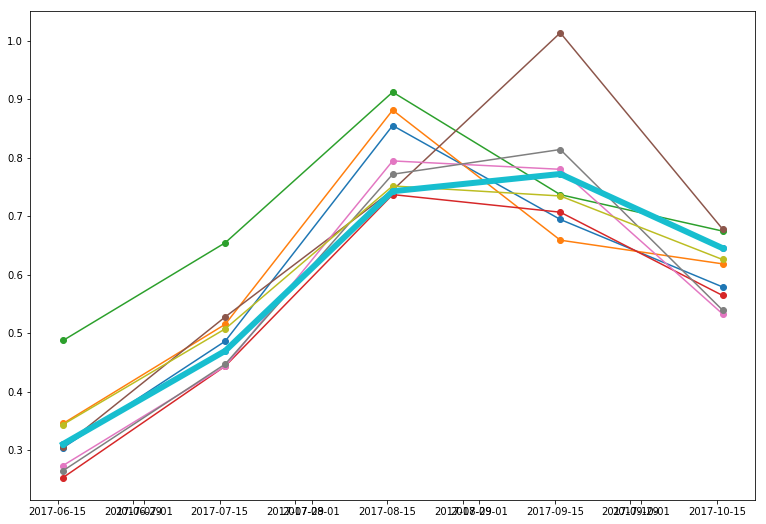

In [123]:
%%time
p,a=plt.subplots(figsize=(13,9))
for i in range(9,12):
    for j in range(9,12):
        a.plot(local.time.values, local.chlor_a.isel(lat=i,lon=j).values, 'o-')

a.plot(local.time.values, local.chlor_a.isel(lat=10,lon=10).values, 'o-', linewidth=6)

In [80]:
local.to_netcdf('local.nc')

In [88]:
local=xr.open_dataset('local.nc')
local

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 21, time: 5)
Coordinates:
  * lat      (lat) float32 43.520832 43.645832 43.729168 ... 45.4375 45.520832
  * lon      (lon) float32 -126.39583 -126.27083 ... -124.479164 -124.39583
  * time     (time) datetime64[ns] 2017-06-16T00:30:01 ... 2017-10-16T00:35:00
Data variables:
    chlor_a  (time, lat, lon) float32 ...

In [111]:
l1

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 21, time: 5)
Coordinates:
  * lat      (lat) float32 43.520832 43.645832 43.729168 ... 45.4375 45.520832
  * lon      (lon) float32 -126.39583 -126.27083 ... -124.479164 -124.39583
  * time     (time) datetime64[ns] 2017-06-16T00:30:01 ... 2017-10-16T00:35:00
Data variables:
    chlor_a  (time, lat, lon) float32 ...

In [113]:
# p,a=plt.subplots(figsize=(13,9))
# for t in l1.chlor_a: print(t)  
# a.plot(local.time.values, t.values, 'o-')

for i in range(21): 
    for j in range(21): 
        print(l1.chlor_a[0:5, i, j].values)

[0.18000033 0.31592223 0.29901353 0.4527981  0.27553654]
[0.18108128 0.30831313 0.29184896 0.45067817 0.30733544]
[0.1756177  0.27087578 0.30185446 0.4411838  0.33814856]
[0.18441194 0.2500996  0.28923604 0.41523215 0.36558807]
[0.17976385 0.2718018  0.30505288 0.3710038  0.39999032]
[0.17722073 0.2713793  0.32337844 0.3434988  0.40936273]
[0.18519966 0.25675613 0.32128507 0.32435268 0.45212522]
[0.18871774 0.25559083 0.35770693 0.3334902  0.4847017 ]
[0.19830224 0.25422806 0.37207514 0.361848   0.50184584]
[0.22636953 0.2659014  0.38756728 0.42062676 0.49282482]
[0.23852755 0.28198475 0.37323534 0.41683415 0.5099659 ]
[0.29191607 0.3178499  0.4528117  0.40028384 0.44651428]
[0.35740846 0.34685335 0.5424179  0.4206405  0.43834928]
[0.3318643  0.38578334 0.73631144 0.52173585 0.44147557]
[0.41127226 0.42427364 1.0480422  0.7129801  0.45551774]
[0.48894942 0.5731575  1.0636405  0.7426566  0.48600897]
[0.6581106  1.0044855  1.0615023  0.71082133 0.5842022 ]
[0.78925204 1.0188174  1.193203

[0.24824429 0.39727825 0.50347364 0.69790816 0.5154233 ]
[0.27320686 0.40854874 0.53076375 0.79792154 0.46858472]
[0.27392402 0.4436004  0.7946731  0.7803351  0.53322965]
[0.2650295  0.44738495 0.7719072  0.81417346 0.53969806]
[0.3439948  0.50763154 0.751842   0.7347313  0.6261465 ]
[0.40530324 0.5297435  0.7542751  0.76099116 0.66466624]
[0.6104753 0.5282949 0.7420269 0.7639761 0.7094877]
[0.68017066 0.5301805  0.8852256  0.93321913 0.77293915]
[0.7050555 0.5916714 0.9464971 1.0633352 0.77267  ]
[0.9002852  0.8481102  1.234079   1.3294805  0.83388776]
[0.9624778 1.4257542 1.4118215 1.3478295 0.9604851]
[0.960031  2.681535  2.2744534 1.1797727 1.1653655]
[0.81814635 3.4427745  4.1624947  2.119761   1.3937085 ]
[0.7155076 6.4636006 5.7293444 2.9607236 1.8443735]
[0.23181926 0.23551343 0.45145524 0.3602314  0.46635652]
[0.25933757 0.23769073 0.4583102  0.39299458 0.5272398 ]
[0.25522405 0.2577707  0.4681771  0.40769458 0.48708066]
[0.24067365 0.25116366 0.46441785 0.4265588  0.50306517]

In [ ]:
local = cb.reindex_like()

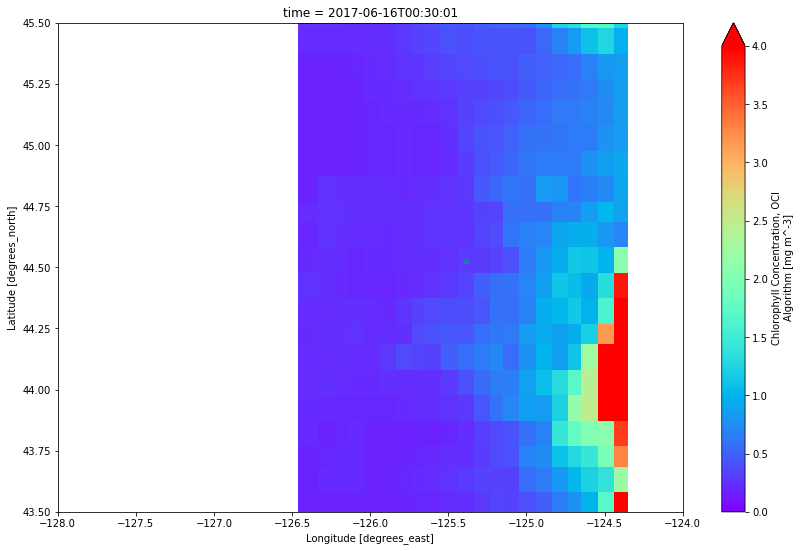

In [114]:
local.chlor_a[0].plot(figsize=(14,9),cmap=plt.cm.rainbow,vmin=0.00, vmax=4.0)
plt.xlim(-128,-124); plt.ylim(43.5,45.5); plt.plot(-125.38966, 44.52897, '^')

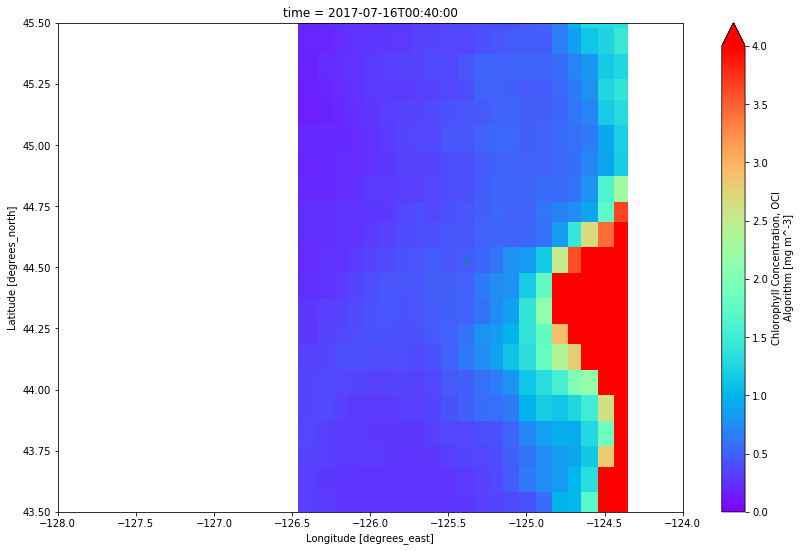

In [115]:
local.chlor_a[1].plot(figsize=(14,9),cmap=plt.cm.rainbow,vmin=0.00, vmax=4.0)
plt.xlim(-128,-124); plt.ylim(43.5,45.5); plt.plot(-125.38966, 44.52897, '^')

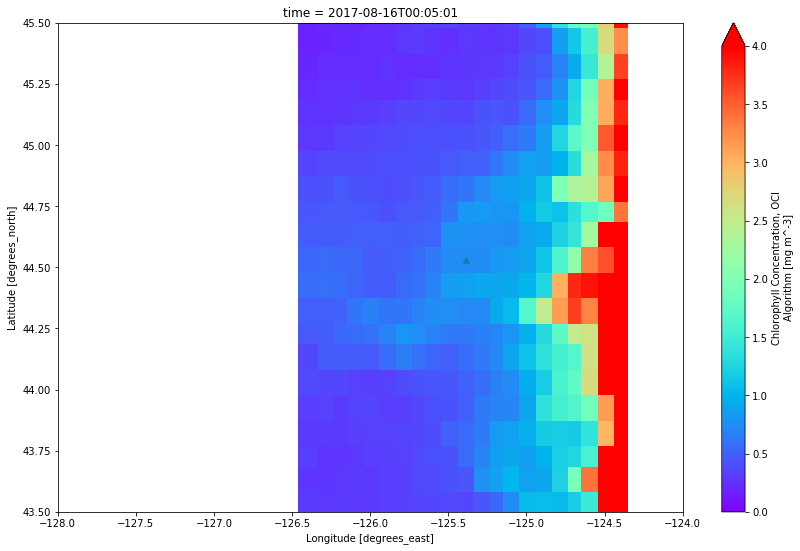

In [116]:
local.chlor_a[2].plot(figsize=(14,9),cmap=plt.cm.rainbow,vmin=0.00, vmax=4.0)
plt.xlim(-128,-124); plt.ylim(43.5,45.5); plt.plot(-125.38966, 44.52897, '^')

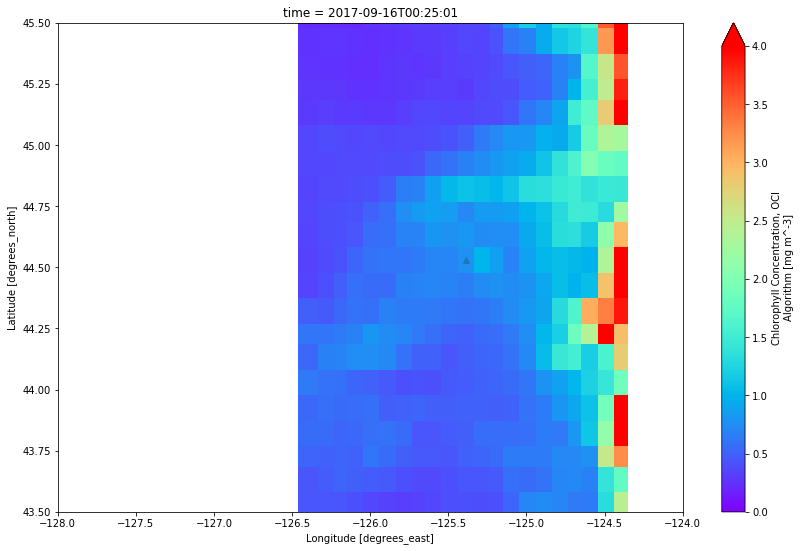

In [117]:
local.chlor_a[3].plot(figsize=(14,9),cmap=plt.cm.rainbow,vmin=0.00, vmax=4.0)
plt.xlim(-128,-124); plt.ylim(43.5,45.5); plt.plot(-125.38966, 44.52897, '^')

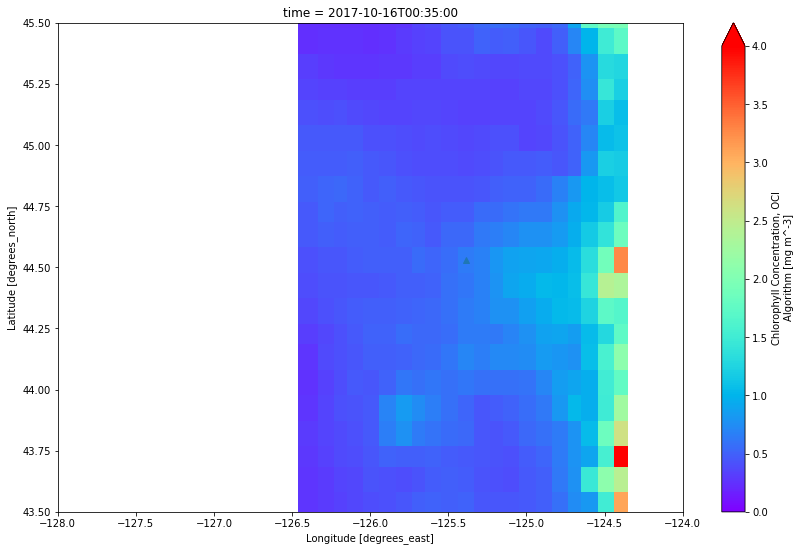

In [118]:
local.chlor_a[4].plot(figsize=(14,9),cmap=plt.cm.rainbow,vmin=0.00, vmax=4.0)
plt.xlim(-128,-124); plt.ylim(43.5,45.5); plt.plot(-125.38966, 44.52897, '^')

In [ ]:
ca=xr.open_rasterio('./chlora.tif').to_dataset(name='chlora')
ca

In [ ]:
ca.chlora

In [ ]:
cad=ca.where(ca.chlora<1.4)
cad.chlora.plot(figsize=(14,9),cmap=plt.cm.rainbow,vmin=0.00, vmax=1.0)
plt.xlim(-128,-124)
plt.ylim(43.5,45.5)
plt.plot(-125.38966, 44.52897, '^')
# a=p.axes()
# a.set(xlim=(-155,-135))

In [ ]:
float(ca.sel(band=0,y=44.52897,x=-125.38966, method='nearest').values)

In [ ]:
for x in np.arange(-125.5, -125.0, 0.1):
    for y in np.arange(44.3, 44.8, 0.1):
        print(float(ca.sel(band=0,y=y,x=x, method='nearest').values))